In [1]:
%load_ext autoreload
%autoreload 2

# Preprocess Amazon Video Games (2014)

In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import scipy.sparse

import teaser.util as util

In [3]:
DATA_DIR = Path('../../data/Amazon Video Games/raw')

# Parsing
# INTERACTIONS_PATH = DATA_DIR / 'ratings_Video_Games.csv'
INTERACTIONS_PATH = DATA_DIR / 'reviews_Video_Games_5.json'
ITEMS_PATH = DATA_DIR / 'meta_Video_Games.json'

# Parse ids
ITEM_ID = 'itemId'
USER_ID = 'userId'
RATING_ID = 'rating'

# For output
T_ITEM_ID = 'itemId'
T_USER_ID = 'userId'

OUTPUT_DIR = Path('../../data/Amazon Video Games/')
OUTPUT_INTERACTIONS_PATH = OUTPUT_DIR / 'interactions.csv'
OUTPUT_FEATURES_PATH = OUTPUT_DIR / 'features.csv'

# For preprocessing
# MIN_USERS_PER_ITEM = 5
# MIN_ITEMS_PER_USER = 5

# For split
AMT_VAL_USERS = 2000
AMT_TEST_USERS = 2000
PERC_HISTORY = 0.8
VAL_MIN_ITEMS_PER_USER = 5   # Make sure only users with at least this many items are selected for validation

# For reproducibility
SEED = 42

## Parse interaction data

In [4]:
interactions = pd.read_json(INTERACTIONS_PATH, lines=True)[['reviewerID','asin','overall']]
interactions = interactions.rename(columns={'reviewerID': USER_ID, 'asin': ITEM_ID, 'overall': RATING_ID})
interactions

,userId,itemId,rating
0,A2HD75EMZR8QLN,0700099867,1
1,A3UR8NLLY1ZHCX,0700099867,4
2,A1INA0F5CWW3J4,0700099867,1
3,A1DLMTOTHQ4AST,0700099867,3
4,A361M14PU2GUEG,0700099867,4
...,...,...,...
231775,A1ICREREXO9J81,B00KHECZXO,5
231776,A3VVMIMMTYQV5F,B00KHECZXO,1
231777,A1DD4B97M4DUC5,B00KHECZXO,1
231778,A2Q9CNJ4T6ZK99,B00KHECZXO,1


In [5]:
# interactions = pd.read_csv(INTERACTIONS_PATH, names=[USER_ID, ITEM_ID, RATING_ID, 'timestamp'], usecols=[ITEM_ID, USER_ID, RATING_ID])
# interactions

In [6]:
# Only counts ratings of 4 or higher as positive
interactions = interactions[interactions[RATING_ID] >= 4]
interactions.drop(columns=[RATING_ID], inplace=True)
interactions

/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/core/frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,userId,itemId
1,A3UR8NLLY1ZHCX,0700099867
4,A361M14PU2GUEG,0700099867
5,A2UTRVO4FDCBH6,0700099867
6,AN3YYDZAS3O1Y,0700099867
8,A1QJJU33VNC4S7,0700099867
...,...,...
231768,A3D8VPZNKYIAP0,B00KAI3KW2
231769,AJQB6I00X8WAI,B00KAI3KW2
231771,A2IGEPJJYKMOWK,B00KAI3KW2
231773,A3PG9EEZMT9CJF,B00KAI3KW2


## Filter users and items

In [7]:
# item_counts = interactions.value_counts(ITEM_ID)
# remaining_items = set(item_counts.index[item_counts > MIN_USERS_PER_ITEM])
# interactions = interactions[interactions[ITEM_ID].isin(remaining_items)]

In [8]:
# user_counts = interactions.value_counts(USER_ID)
# remaining_users = set(user_counts.index[user_counts > MIN_ITEMS_PER_USER])
# interactions = interactions[interactions[USER_ID].isin(remaining_users)]

In [9]:
# Might have some items with less than MIN_USERS_PER_ITEM users because the users could have been removed
interactions.value_counts(ITEM_ID)

itemId
B00BGA9WK2    682
B0015AARJI    585
B007CM0K86    460
B002VBWIP6    438
B000B9RI14    407
             ... 
B00002SVQ2      1
B000O5DPJE      1
B0083VTNQA      1
B00006IKCK      1
B00KHECZXO      1
Length: 10622, dtype: int64

In [10]:
interactions.value_counts(USER_ID)

userId
A3V6Z4RCDGRC44    659
AJKWF4W7QD4NS     426
A3W4D8XOGLWUN5    333
A29BQ6B90Y1R5F    326
AFV2584U13XP3     287
                 ... 
AN617I1HX9OBW       1
A2TBIU2VW9DE4U      1
A2TBGYG7BI8SWD      1
A300S1GRHOCCR5      1
A2M4KF5NTTZY2R      1
Length: 24072, dtype: int64

In [11]:
used_items = set(interactions[ITEM_ID])
# used_items

## Parse metadata

In [12]:
def parse_json_file(path):
    with open(path, 'r') as f:
        for l in f.readlines():
            yield eval(l)

def getDF_json(path):
    i = 0
    df = {}
    for d in parse_json_file(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

In [13]:
items = getDF_json(ITEMS_PATH).rename(columns={'asin': ITEM_ID}).drop(columns=['imUrl', 'related', 'salesRank']).set_index(ITEM_ID)
print("Original items:", len(items))
# Only keep metadata of used items
items = items[items.index.isin(used_items)]
items

Original items: 50953


,description,price,categories,title,brand
itemId,,,,,
0700099867,Dirt 3 is a popular rally racing game for Play...,246.63,"[[Video Games, PC, Games]]",NaN,NaN
6050036071,These are the official Disney Microphones for ...,39.99,"[[Video Games, PlayStation 3, Accessories, Con...",NaN,NaN
7100027950,Nintendo's thematic action-adventure sequel to...,105.63,"[[Video Games, Kids & Family], [Video Games, M...",NaN,NaN
7293000936,Having stunning Nintendo Wii High Definition G...,6.05,"[[Video Games, Wii, Accessories, Cables & Adap...",NaN,NaN
8176503290,Tom Clancy's H.A.W.X. 2 plunges fans into an e...,49.99,"[[Video Games, PC, Games]]",NaN,NaN
...,...,...,...,...,...
B00JQ8YH6A,"Ever since the Secret of the Scarlet Hand, the...",44.54,"[[Video Games, Mac, Games], [Video Games, PC, ...",NaN,NaN
B00JQHU9RC,,19.99,"[[Video Games, Kids & Family, PlayStation 3, G...",NaN,NaN
B00JXW6GE0,Announcing:\nA high quality ergonomic gaming m...,NaN,"[[Video Games, Mac, Accessories, Gaming Mice]]",NaN,NaN


/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:xlabel='brand'>

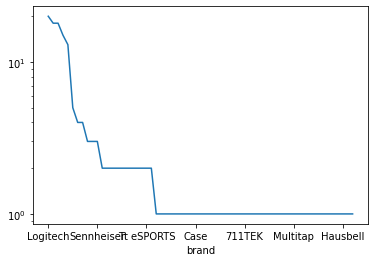

In [14]:
counts = items.value_counts('brand')
counts.plot(logy=True)

In [15]:
MIN_RBAND_OCCURRENCES = 2
allowed = counts[counts > MIN_RBAND_OCCURRENCES].index
print("brands", len(allowed))
items.loc[~items['brand'].isin(allowed), 'brand'] = np.nan

brands 11


### Bin price

In [16]:
items['price'] = pd.qcut(items['price'].astype(np.float), 10, duplicates='drop')
items['price']

itemId
0700099867    (123.974, 999.99]
6050036071       (38.99, 49.99]
7100027950     (69.99, 123.974]
7293000936        (-0.001, 8.9]
8176503290       (38.99, 49.99]
                    ...        
B00JQ8YH6A       (38.99, 49.99]
B00JQHU9RC       (14.99, 19.99]
B00JXW6GE0                  NaN
B00KAI3KW2    (123.974, 999.99]
B00KHECZXO    (123.974, 999.99]
Name: price, Length: 10622, dtype: category
Categories (9, interval[float64]): [(-0.001, 8.9] < (8.9, 14.99] < (14.99, 19.99] < (19.99, 29.99] ... (38.99, 49.99] < (49.99, 69.99] < (69.99, 123.974] < (123.974, 999.99]]

#### Transform lists

In [17]:
def stack_list(series):
    return series.apply(pd.Series).stack()

def create_list_filter(f):
    """ Creates a filter function to apply to a list. """
    def filt(l):
        return list(filter(f, l))
    return filt

In [18]:
# item = items[items[ITEM_ID] == 'B00LCLV730']
# item.iloc[0]['categories']

/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/env/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


<AxesSubplot:>

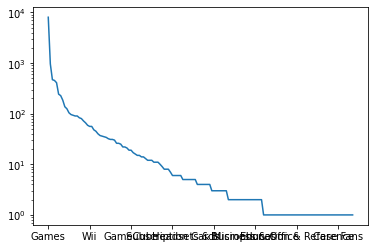

In [20]:
categories = items['categories'].apply(lambda x: list(set([y[-1] for y in list(x)])))
counts = categories.explode().value_counts()
counts.plot(logy=True)

In [21]:
MIN_CATEGORY_OCCURRENCES = 2
allowed = counts[counts > MIN_CATEGORY_OCCURRENCES].index
print(len(allowed))
items['categories'] = categories.apply(create_list_filter(lambda y: y in allowed))

87


### Mine text for keywords

In [22]:
items['title'].fillna("", inplace=True)
items['description'].fillna("", inplace=True)
text = items['title'] + ' ' + items['description']
text

itemId
0700099867     Dirt 3 is a popular rally racing game for Pla...
6050036071     These are the official Disney Microphones for...
7100027950     Nintendo's thematic action-adventure sequel t...
7293000936     Having stunning Nintendo Wii High Definition ...
8176503290     Tom Clancy's H.A.W.X. 2 plunges fans into an ...
                                    ...                        
B00JQ8YH6A     Ever since the Secret of the Scarlet Hand, th...
B00JQHU9RC                                                     
B00JXW6GE0     Announcing:\nA high quality ergonomic gaming ...
B00KAI3KW2                                                     
B00KHECZXO                Nintendo Wii U 32GB Mario Kart Bundle
Length: 10622, dtype: object

In [23]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
# Use words that occur not too ofter, but often enough to be usefull
# Cutoffs selected to limit amout of features while retraining the most interesting ones
vectorizer = CountVectorizer(strip_accents='ascii', stop_words=['english'], max_df=.3, min_df=.01)
c = vectorizer.fit_transform(text)
c

<10622x1581 sparse matrix of type '<class 'numpy.int64'>'
	with 582531 stored elements in Compressed Sparse Row format>

In [26]:
c.data[c.data >= 1] = 1
c.data

array([1, 1, 1, ..., 1, 1, 1])

In [27]:
columns = [x[0] for x in sorted(vectorizer.vocabulary_.items(), key=lambda x: x[1])] 
columns

['000',
 '01',
 '10',
 '100',
 '10px',
 '11',
 '11px',
 '12',
 '125px',
 '12px',
 '146',
 '15',
 '150',
 '15px',
 '16',
 '1px',
 '20',
 '200',
 '2000',
 '20px',
 '24',
 '25',
 '250px',
 '2is',
 '30',
 '32',
 '360',
 '3d',
 '3ds',
 '3em',
 '40',
 '50',
 '60',
 '64',
 '999999',
 '9dc4d8',
 'abilities',
 'ability',
 'able',
 'about',
 'above',
 'ac',
 'access',
 'accessible',
 'accessories',
 'acclaimed',
 'accuracy',
 'accurate',
 'achieve',
 'across',
 'act',
 'action',
 'actions',
 'activate',
 'activities',
 'actual',
 'actually',
 'adapter',
 'add',
 'added',
 'addictive',
 'adding',
 'addition',
 'additional',
 'adds',
 'adrenaline',
 'advance',
 'advanced',
 'advantage',
 'adventure',
 'adventures',
 'affect',
 'after',
 'again',
 'against',
 'age',
 'agent',
 'ages',
 'ago',
 'ai',
 'aid',
 'air',
 'alien',
 'alike',
 'alive',
 'allies',
 'allow',
 'allowing',
 'allows',
 'almost',
 'alone',
 'along',
 'already',
 'also',
 'although',
 'always',
 'amazing',
 'amazon',
 'america',


In [28]:
keywords = pd.DataFrame.sparse.from_spmatrix(c, index=text.index, columns=columns)
keywords

,000,01,10,100,10px,11,11px,12,125px,12px,...,x2019,xbox,xp,year,years,yet,york,young,yours,yourself
itemId,,,,,,,,,,,,,,,,,,,,,
0700099867,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6050036071,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
7100027950,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
7293000936,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8176503290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00JQ8YH6A,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00JQHU9RC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
B00JXW6GE0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Processed metadata

In [29]:
items

,description,price,categories,title,brand
itemId,,,,,
0700099867,Dirt 3 is a popular rally racing game for Play...,"(123.974, 999.99]",[Games],,NaN
6050036071,These are the official Disney Microphones for ...,"(38.99, 49.99]",[Microphones],,NaN
7100027950,Nintendo's thematic action-adventure sequel to...,"(69.99, 123.974]","[Games, Kids & Family]",,NaN
7293000936,Having stunning Nintendo Wii High Definition G...,"(-0.001, 8.9]",[Cables],,NaN
8176503290,Tom Clancy's H.A.W.X. 2 plunges fans into an e...,"(38.99, 49.99]",[Games],,NaN
...,...,...,...,...,...
B00JQ8YH6A,"Ever since the Secret of the Scarlet Hand, the...","(38.99, 49.99]",[Games],,NaN
B00JQHU9RC,,"(14.99, 19.99]",[Games],,NaN
B00JXW6GE0,Announcing:\nA high quality ergonomic gaming m...,NaN,[Gaming Mice],,NaN


## Map metadata to one hot features

In [30]:
def get_dummies(df):
    return pd.get_dummies(df, prefix_sep='_', sparse=False)

def get_list_dummies(series):
    """ Creates dummies for list type. kwargs are passed to get_dummies(). """
    return get_dummies(stack_list(series)).groupby(level=0).sum()

In [31]:
list_types = ['categories']
categorical_types = ['price', 'brand']

In [32]:
metadata = get_dummies(items[categorical_types])
metadata

,"price_(-0.001, 8.9]","price_(8.9, 14.99]","price_(14.99, 19.99]","price_(19.99, 29.99]","price_(29.99, 38.99]","price_(38.99, 49.99]","price_(49.99, 69.99]","price_(69.99, 123.974]","price_(123.974, 999.99]",brand_CH Products,brand_Corsair,brand_Generic,brand_Logitech,brand_Mad Catz,brand_Microsoft,brand_ROCCAT,brand_Razer,brand_Sennheiser,brand_SteelSeries,brand_Turtle Beach
itemId,,,,,,,,,,,,,,,,,,,,
0700099867,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
6050036071,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7100027950,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
7293000936,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8176503290,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00JQ8YH6A,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00JQHU9RC,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
B00JXW6GE0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
for col in list_types:
    dummies = get_list_dummies(items[col])
    metadata = pd.concat([metadata, dummies], axis=1)

In [34]:
# Join keywords
metadata = pd.concat([metadata, keywords.sparse.to_dense()], axis=1)

In [35]:
# Set zeros to nan for sparse saving
metadata[metadata == 0] = np.nan
metadata[ITEM_ID] = metadata.index
metadata

,"price_(-0.001, 8.9]","price_(8.9, 14.99]","price_(14.99, 19.99]","price_(19.99, 29.99]","price_(29.99, 38.99]","price_(38.99, 49.99]","price_(49.99, 69.99]","price_(69.99, 123.974]","price_(123.974, 999.99]",brand_CH Products,...,xbox,xp,year,years,yet,york,young,yours,yourself,itemId
itemId,,,,,,,,,,,,,,,,,,,,,
0700099867,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0700099867
6050036071,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6050036071
7100027950,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,7100027950
7293000936,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7293000936
8176503290,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8176503290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
B00JQ8YH6A,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00JQ8YH6A
B00JQHU9RC,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00JQHU9RC
B00JXW6GE0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B00JXW6GE0


## Filter metadata (if needed)

In [36]:
# amount of occurences per feature
metadata.drop(columns=[ITEM_ID]).sum(axis=0).sort_values()

Audio & Video Accessories       3.0
Cables & Accessories            3.0
brand_Turtle Beach              3.0
Home Publishing                 3.0
PC Microphones                  3.0
                              ...  
will                         2936.0
are                          3037.0
can                          3117.0
by                           3181.0
Games                        8031.0
Length: 1688, dtype: float64

In [37]:
# amount of features per item
metadata.drop(columns=[ITEM_ID]).sum(axis=1).sort_values()

itemId
B000IFRPLO      1.0
B00004XOMV      1.0
B00005RDYT      1.0
B000FW4YOQ      1.0
B0009I95TK      1.0
              ...  
B0028ZNX68    374.0
B008TTPRE8    425.0
B000KGD1GO    508.0
B000KIBABA    508.0
B000N4MSAS    508.0
Length: 10622, dtype: float64

## Remap ids

In [38]:
util.remap_ids(interactions, metadata, col=ITEM_ID)
util.remap_ids(interactions, col=USER_ID)[0]

/home/joey/Documents/Informatica/PhD/2020-2021/SI EDLAE/Code/teaser/util.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = id_mapping[df[col]].values


,userId,itemId
1,14526,4077
4,20257,4077
5,18520,4077
6,19331,4077
8,5030,4077
...,...,...
231768,14641,8107
231769,8608,8107
231771,3666,8107
231773,21109,8107


## Convert to csr matrix

In [39]:
X = util.interactions_df_to_csr(interactions, ITEM_ID, USER_ID)
X

<24072x10622 sparse matrix of type '<class 'numpy.int8'>'
	with 174989 stored elements in Compressed Sparse Row format>

## Print statistics

In [40]:
amt_users, amt_items = X.shape
i_density = X.getnnz() / (amt_users * amt_items)
metadata_names = categorical_types + list_types
S = scipy.sparse.csr_matrix(metadata.set_index(ITEM_ID).values.astype(np.int8))
_, amt_features = S.shape
f_density = S.getnnz() / (amt_features * amt_items)

print(f"# users: {amt_users}")
print(f"# items: {amt_items}")
print(f"inter. density: {i_density:.3%}")
print(f"columns: {', '.join(metadata_names)}")
print(f"# features: {amt_features}")
print(f"feature density: {f_density:.3%}")

# users: 24072
# items: 10622
inter. density: 0.068%
columns: price, brand, categories
# features: 1688
feature density: 3.381%


## Split interactions with strong generalization scheme

In [43]:
Xtrainval, Xtest_in, Xtest_out = util.split(X, test_users=AMT_TEST_USERS, perc_history=PERC_HISTORY, min_interactions=VAL_MIN_ITEMS_PER_USER, seed=SEED)
Xtrain, Xval_in, Xval_out = util.split(Xtrainval, test_users=AMT_VAL_USERS, perc_history=PERC_HISTORY, min_interactions=VAL_MIN_ITEMS_PER_USER, seed=SEED)

## Save files

In [44]:
basename = OUTPUT_INTERACTIONS_PATH.stem

util.store_interactions(Xtrain, OUTPUT_DIR / f"{basename}.train.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xtest_in, OUTPUT_DIR / f"{basename}.testin.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xtest_out, OUTPUT_DIR / f"{basename}.testout.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xval_in, OUTPUT_DIR / f"{basename}.valin.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)
util.store_interactions(Xval_out, OUTPUT_DIR / f"{basename}.valout.csv", item_id=T_ITEM_ID, user_id=T_USER_ID)

metadata.rename(columns={ITEM_ID: T_ITEM_ID}).to_csv(OUTPUT_FEATURES_PATH, index=False)